In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
import tensorflow as tf

from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import l2_regularizer
from tensorflow.contrib.layers import dropout

tf.__version__

'1.0.0'

In [3]:
def load_mnist():
    mnist = fetch_mldata("MNIST Original")
    X = (mnist.data / 255).astype(np.float32)
    X_train, X_test = train_test_split(X, test_size=10000)
    X_train = shuffle(X_train)
    def _generator():
        i, n = 0, X_train.shape[0]
        batch_size = 64
        while True:
            i %= n
            yield X_train[i:i+batch_size]
            i += batch_size
    return _generator(), X_test

train_generator, test_data = load_mnist()

## naive autoencoder

In [8]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # coding
n_hidden3 = n_hidden1
n_outputs = n_inputs

naive_graph = tf.Graph()

he_initializer = variance_scaling_initializer()
regularizer = l2_regularizer(0.0005)
activation = tf.nn.elu

with naive_graph.as_default():
    X = tf.placeholder(tf.float32, [None, n_inputs], name="X")
    
    with tf.name_scope("autencoder"):
        W1 = tf.Variable(he_initializer([n_inputs, n_hidden1]), name="W1")
        b1 = tf.Variable(tf.zeros([n_hidden1]), name="b1")

        W2 = tf.Variable(he_initializer([n_hidden1, n_hidden2]), name="W2")
        b2 = tf.Variable(tf.zeros(n_hidden2), name="b2")

        W3 = tf.transpose(W2, name="W3")
        b3 = tf.Variable(tf.zeros(n_hidden3), name="b3")

        W4 = tf.transpose(W1, name="W4")
        b4 = tf.Variable(tf.zeros(n_outputs), name="b4")

        h1 = activation(tf.add(tf.matmul(X, W1), b1), name="h1")
        h2 = activation(tf.add(tf.matmul(h1, W2), b2), name="h2") # coding
        h3 = activation(tf.add(tf.matmul(h2, W3), b3), name="h3")
        output = tf.add(tf.matmul(h3, W4), b4, name="output")
        
    with tf.name_scope("metrics"):
        mse = tf.reduce_mean(tf.square(X-output))
        l2 = regularizer(W1) + regularizer(W2)
        loss = mse + l2
        
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss)
        
    with tf.name_scope("summary"):
        mse_summary = tf.summary.scalar("mse", mse)
        l2_summary = tf.summary.scalar("l2", l2)
        loss_summary = tf.summary.scalar("loss", loss)
        all_summary = tf.summary.merge_all()
        
    writer = tf.summary.FileWriter("naive-autoencoder", graph=naive_graph)
    init = tf.global_variables_initializer()

In [11]:
with tf.Session(graph=naive_graph) as sess:
    init.run(session=sess)
    for i in range(2000):
        X_batch = next(train_generator)
        sess.run(train_op, feed_dict={X: X_batch})
        if i % 100 == 0:
            train_loss = loss.eval(session=sess, feed_dict={X: X_batch})
            test_loss, reconstructed = sess.run([loss, output], feed_dict={X: test_data})
            print(train_loss, test_loss)

0.393018 0.397112
0.126743 0.127065
0.0653887 0.0664584
0.0469329 0.0467451
0.0382816 0.0392785
0.0361212 0.0362116
0.0344313 0.0349302
0.0322275 0.0343078
0.0337885 0.0340689
0.0338067 0.0339335
0.0335416 0.0338502
0.0349837 0.0338299
0.0323695 0.0338105
0.0322739 0.0337519
0.0334349 0.0337565
0.0333161 0.0337402
0.0345602 0.0338881
0.0336156 0.0337806
0.0333488 0.0337825
0.0329992 0.0338839


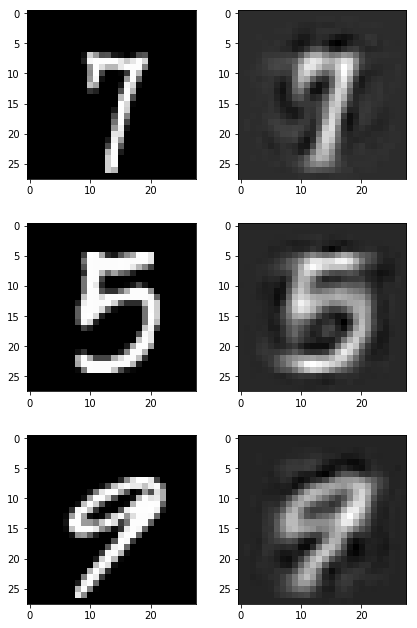

In [19]:
n_samples = 3
fig, axes = plt.subplots(n_samples, 2, figsize=(2*3, n_samples*3))
fig.tight_layout()
for a, i in enumerate(np.random.randint(0, test_data.shape[0], n_samples)):
    axes[a, 0].imshow(test_data[i].reshape(28, 28), cmap=plt.cm.gray)
    axes[a, 1].imshow(reconstructed[i].reshape(28, 28), cmap=plt.cm.gray)

## autoencoder in single graph in phases

In [148]:
phase_graph = tf.Graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150 # encoding
n_hidden3 = n_hidden1
n_outputs = n_inputs

activation = tf.nn.elu
regularizer = l2_regularizer(1e-4)
initializer = variance_scaling_initializer()

with phase_graph.as_default():
    X = tf.placeholder(tf.float32, [None, n_inputs], name="X")
    
    with tf.name_scope("autoencoder"):
    
        W1 = tf.Variable(initializer([n_inputs, n_hidden1]), name="W1")
        W2 = tf.Variable(initializer([n_hidden1, n_hidden2]), name="W2")
#         W3 = tf.Variable(initializer([n_hidden2, n_hidden3]), name="W3")
#         W4 = tf.Variable(initializer([n_hidden3, n_outputs]), name="W4")
        W3 = tf.transpose(W2, name="W3")
        W4 = tf.transpose(W1, name="W4")

        b1 = tf.Variable(tf.zeros(n_hidden1))
        b2 = tf.Variable(tf.zeros(n_hidden2))
        b3 = tf.Variable(tf.zeros(n_hidden3))
        b4 = tf.Variable(tf.zeros(n_outputs))

        h1 = activation(tf.matmul(X, W1) + b1, name="h1")
        h2 = activation(tf.matmul(h1, W2) + b2, name="h2")
        h3 = activation(tf.matmul(h2, W3) + b3, name="h3")
        output = tf.add(tf.matmul(h3, W4), b4, name="output")
        
    # pretend h2 and h3 are absent
    with tf.name_scope("phase1"):
        # bypass h2(encode) and h3(decode) layer
        # still need the decode layer which is (W4, b4)
        p1_output = tf.matmul(h1, W4) + b4 
        p1_mse = tf.reduce_mean(tf.square(X-p1_output))
        p1_l2 = regularizer(W1) + regularizer(W4)
        p1_loss = p1_mse + p1_l2
        optimizer = tf.train.AdamOptimizer()
        p1_train_op = optimizer.minimize(p1_loss)
    
    # pretend h1 and h4 (output) are absent
    with tf.name_scope("phase2"):
        # middle layers of sandwitch
        p2_mse = tf.reduce_mean(tf.square(h1-h3))
        p2_l2 = regularizer(W2) + regularizer(W3)
        p2_loss = p2_mse + p2_l2
        optimizer = tf.train.AdamOptimizer()
        p2_train_op = optimizer.minimize(p2_loss, var_list=[W2, b2, b3])
        
    mse = tf.reduce_mean(tf.square(output-X))
        
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [149]:
train_ops = [p1_train_op, p2_train_op]
mses = [p1_mse, p2_mse]
losses = [p1_loss, p2_loss]

with tf.Session(graph=phase_graph) as sess:
    init.run()
    for phase in range(2):
        print("training phase %i" % phase)
        for epoch in range(2000):
            X_batch = next(train_generator)
            sess.run(train_ops[phase], feed_dict={X: X_batch})
            if epoch % 100 == 0:
                train_mse = mses[phase].eval(feed_dict={X: X_batch})
                test_mse = mses[phase].eval(feed_dict={X: test_data})
                train_overall_mse = mse.eval(feed_dict={X: X_batch})
                test_overall_mse = mse.eval(feed_dict={X: test_data})
                print(train_mse, test_mse, train_overall_mse, test_overall_mse)
    reconstructed = output.eval(feed_dict={X: test_data})
    saver.save(sess, "./phase_autoencoder.ckpt")

training phase 0
0.107751 0.111108 0.214101 0.215439
0.010557 0.0116785 0.103356 0.102025
0.00744649 0.00735059 0.0734342 0.0730883
0.00680881 0.00703758 0.0561302 0.0564116
0.00669167 0.00715085 0.0476137 0.0499988
0.00721191 0.00727975 0.0467023 0.0475359
0.00669146 0.00739205 0.0411067 0.0457745
0.00737618 0.00744077 0.0451244 0.0453868
0.0071989 0.00744586 0.0460059 0.045077
0.0072174 0.00750942 0.0454987 0.0449366
0.00754031 0.00755529 0.0453604 0.0445144
0.00699697 0.00757572 0.0453985 0.045089
0.00705724 0.0076002 0.046278 0.0449293
0.00761059 0.00766272 0.0437614 0.0445511
0.00799973 0.00759193 0.044674 0.0446563
0.00805198 0.00762206 0.0481277 0.0446183
0.007417 0.00764146 0.0446149 0.0440236
0.00781077 0.00763062 0.0456294 0.0442611
0.00777905 0.00763234 0.0471515 0.0444553
0.00755775 0.00761492 0.044974 0.0440427
training phase 1
0.284294 0.283015 0.0407759 0.0405623
0.0390506 0.0372725 0.0182329 0.0171157
0.0174101 0.0179343 0.0126954 0.0130039
0.00960898 0.00943031 0.01121

In [150]:
# verify the learning effect
tf.reset_default_graph()
saver = tf.train.import_meta_graph("./phase_autoencoder.ckpt.meta")
graph = tf.get_default_graph()
X = graph.get_tensor_by_name("X:0")
output = graph.get_tensor_by_name("autoencoder/output:0")
with tf.Session() as sess:
    saver.restore(sess, "./phase_autoencoder.ckpt")
    reconstructed = output.eval(feed_dict={X: test_data})

In [151]:
np.mean(np.square(reconstructed-test_data))

0.0093626566

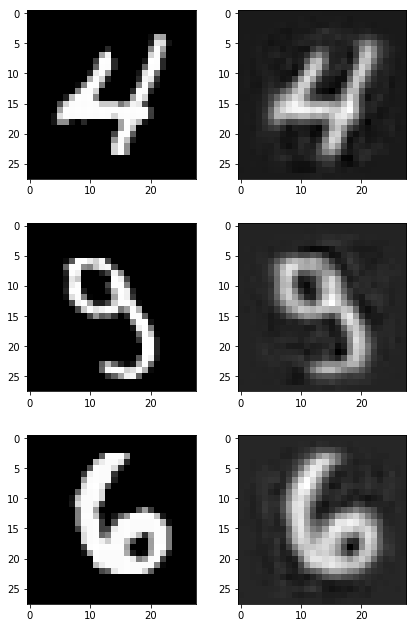

In [153]:
n_samples = 3
fig, axes = plt.subplots(n_samples, 2, figsize=(2*3, n_samples*3))
fig.tight_layout()
for a, i in enumerate(np.random.randint(0, test_data.shape[0], n_samples)):
    axes[a, 0].imshow(test_data[i].reshape(28, 28), cmap=plt.cm.gray)
    axes[a, 1].imshow(reconstructed[i].reshape(28, 28), cmap=plt.cm.gray)

## stacked denoising autoencoder - gaussian/dropout noise

In [177]:
noise_graph = tf.Graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs
keep_prob = 0.7

with noise_graph.as_default():

    he_initializer = variance_scaling_initializer()
    regularizer = l2_regularizer(1e-4)
    activation = tf.nn.elu
    is_training = tf.placeholder_with_default(False, [])

    def add_noise(signal, noise_type):
        if noise_type is "gaussian":
            noise = tf.truncated_normal(tf.shape(signal), stddev=0.5)
            return signal + noise
        elif noise_type is "dropout":
            return dropout(signal, keep_prob=keep_prob, is_training=is_training)
        else:
            return signal
        
    X = tf.placeholder(tf.float32, [None, n_inputs])
    X_noise = add_noise(X, "dropout")
    
    with tf.name_scope("autoencoder"):
        W1 = tf.Variable(he_initializer([n_inputs, n_hidden1]), name="W1")
        W2 = tf.Variable(he_initializer([n_hidden1, n_hidden2]), name="W2")
        W3 = tf.transpose(W2, name="W3")
        W4 = tf.transpose(W1, name="W4")
        
        b1 = tf.Variable(tf.zeros([n_hidden1]), name="b1")
        b2 = tf.Variable(tf.zeros([n_hidden2]), name="b2")
        b3 = tf.Variable(tf.zeros([n_hidden3]), name="b3")
        b4 = tf.Variable(tf.zeros([n_outputs]), name="b4")
        
        h1 = activation(tf.matmul(X_noise, W1) + b1)
        h2 = activation(tf.matmul(h1, W2) + b2)
        h3 = activation(tf.matmul(h2, W3) + b3)
        output = tf.matmul(h3, W4) + b4
        
    with tf.name_scope("metrics"):
        mse = tf.reduce_mean(tf.square(X-output))
        l2 = regularizer(W1) + regularizer(W2)
        loss = mse + l2
    
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(1e-2)
        train_op = optimizer.minimize(loss)
        
    init = tf.global_variables_initializer()

In [181]:
with tf.Session(graph=noise_graph) as sess:
    init.run()
    for epoch in range(2000):
        X_batch = next(train_generator)
        sess.run(train_op, feed_dict={X: X_batch, is_training:True})
        if epoch % 100 == 0:
            train_mse = sess.run(mse, feed_dict={X: X_batch})
            test_mse = sess.run(mse, feed_dict={X: test_data})
            print(train_mse, test_mse)
    reconstructed = sess.run(output, feed_dict={X: test_data})
    W1_val = W1.eval()

1.93812 1.94719
0.0470208 0.0466323
0.0334188 0.0334375
0.0249784 0.0261771
0.0215623 0.0215921
0.0185586 0.018867
0.0179739 0.0169054
0.0159084 0.0153701
0.0150371 0.0145987
0.0140332 0.0136279
0.0132711 0.0132492
0.0120634 0.0129445
0.012439 0.012482
0.0127899 0.0123665
0.0124603 0.0122165
0.0123169 0.0122813
0.0109856 0.0121827
0.0124306 0.0122716
0.0120582 0.0122767
0.0119616 0.0122664


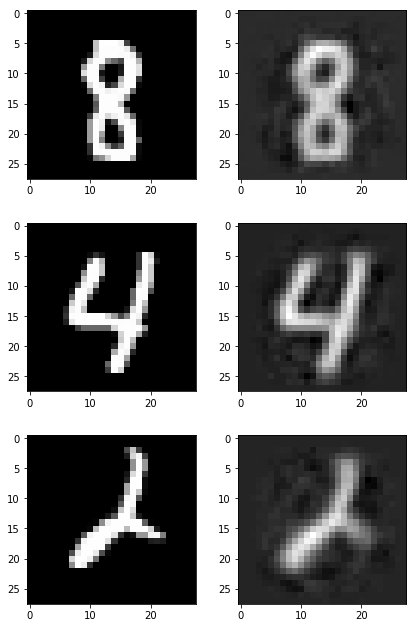

In [191]:
n_samples = 3
fig, axes = plt.subplots(n_samples, 2, figsize=(2*3, n_samples*3))
fig.tight_layout()
for a, i in enumerate(np.random.randint(0, test_data.shape[0], n_samples)):
    axes[a, 0].imshow(test_data[i].reshape(28, 28), cmap=plt.cm.gray)
    axes[a, 1].imshow(reconstructed[i].reshape(28, 28), cmap=plt.cm.gray)

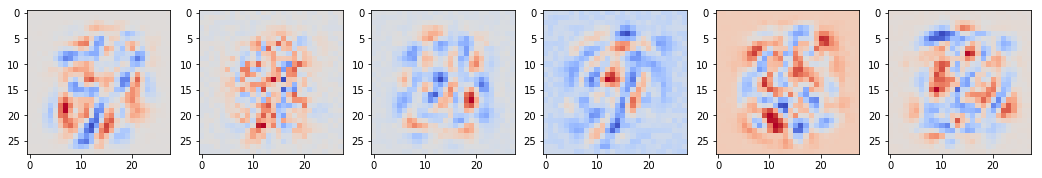

In [192]:
## visualize bottom features, W1
n_samples = 6
visual_weights = W1_val[:, np.random.randint(0, n_hidden1, n_samples)]
fig, axes = plt.subplots(1, n_samples, figsize=(3*n_samples, 3))
for i in range(n_samples):
    axes[i].imshow(visual_weights[:, i].reshape(28, 28), cmap=plt.cm.coolwarm_r)

## sparse encoder

In [193]:
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1-p) * tf.log((1-p) / (1-q))

In [293]:
sparse_graph = tf.Graph()

with sparse_graph.as_default():
    sparsity_target = 0.1
    sparsity_weight = 0.3
    
    n_inputs = 28 * 28
    n_hidden = 1000
    n_outputs = n_inputs
    
    activation = tf.nn.sigmoid
    he_initializer = variance_scaling_initializer()
    
    X = tf.placeholder(tf.float32, [None, n_inputs], name="X")
    
    with tf.name_scope("autoencoder"):
        W1 = tf.Variable(he_initializer([n_inputs, n_hidden]), name="W1")
#         W2 = tf.transpose(W1)
        W2 = tf.Variable(he_initializer([n_hidden, n_outputs]), name="W2")
    
        b1 = tf.Variable(tf.zeros([n_hidden]), name="b1")
        b2 = tf.Variable(tf.zeros([n_outputs]), name="b2")
        
        h1 = activation(tf.matmul(X, W1) + b1)
        logits = tf.matmul(h1, W2) + b2
        output = tf.nn.sigmoid(logits)
    
    with tf.name_scope("metrics"):
        h1_mean = tf.reduce_mean(h1, axis=0)
        sparsity_loss = tf.reduce_mean(kl_divergence(sparsity_target, h1_mean))
        
#         mse = tf.reduce_mean(tf.square(output - X))
#         loss = mse + sparsity_weight * sparsity_loss
        # speed up convergence, for the greater gradient
        xentropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X))
        loss = xentropy + sparsity_weight * sparsity_loss
    
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(1e-2)
        train_op = optimizer.minimize(loss)
        
    with tf.name_scope("summary"):
        h1_mean_summary = tf.summary.histogram("h1_mean_hist", h1_mean)
        all_summary = tf.summary.merge_all()
        
    init = tf.global_variables_initializer()
    
logger = tf.summary.FileWriter("./sparse-autoencoder", graph=sparse_graph)

In [294]:
with tf.Session(graph=sparse_graph) as sess:
    init.run()
    for i in range(4000):
        X_batch = next(train_generator)
        sess.run(train_op, feed_dict={X: X_batch})
        if i % 500 == 0:
            train_metrics = sess.run([loss, xentropy, sparsity_loss],
                                   feed_dict={X: X_batch})
            test_metrics = sess.run([loss, xentropy, sparsity_loss],
                                   feed_dict={X: test_data})
            print(train_metrics + test_metrics)
            summary_val = sess.run(all_summary, feed_dict={X: test_data})
            logger.add_summary(summary_val, global_step=i)
            logger.flush()
    reconstructed = sess.run(output, feed_dict={X: test_data})
    W1_val = sess.run(W1)
    
logger.close()

[0.51628256, 0.45387495, 0.20802534, 0.53710443, 0.47619882, 0.20301861]
[0.078195065, 0.07450375, 0.012304388, 0.078054324, 0.075510658, 0.0084788948]
[0.07183782, 0.069918536, 0.0063976212, 0.073056981, 0.07167837, 0.0045953579]
[0.069245078, 0.06778761, 0.0048582265, 0.07111641, 0.070357829, 0.0025285976]
[0.068004757, 0.066724598, 0.0042672008, 0.069885269, 0.069184102, 0.0023372122]
[0.064994544, 0.063815244, 0.003930992, 0.069345459, 0.068651281, 0.0023139168]
[0.066766255, 0.065693282, 0.0035765755, 0.069206536, 0.068613574, 0.0019765473]
[0.06234118, 0.061346222, 0.0033165282, 0.068657741, 0.068090364, 0.0018912591]


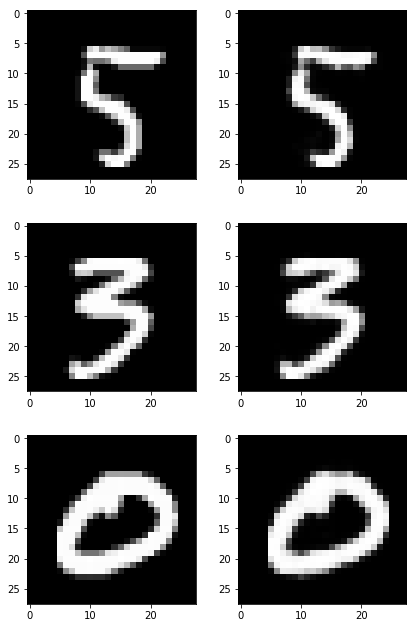

In [295]:
n_samples = 3
fig, axes = plt.subplots(n_samples, 2, figsize=(2*3, n_samples*3))
fig.tight_layout()
for a, i in enumerate(np.random.randint(0, test_data.shape[0], n_samples)):
    axes[a, 0].imshow(test_data[i].reshape(28, 28), cmap=plt.cm.gray)
    axes[a, 1].imshow(reconstructed[i].reshape(28, 28), cmap=plt.cm.gray)

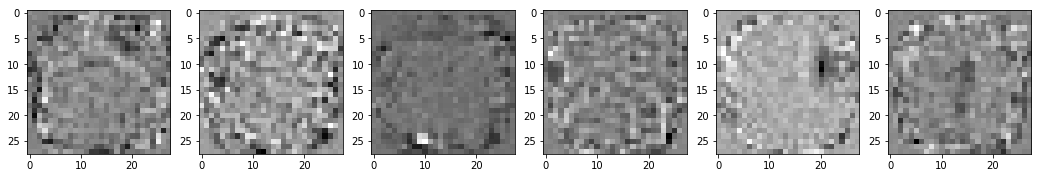

In [296]:
## visualize bottom features, W1
n_samples = 6
visual_weights = W1_val[:, np.random.randint(0, n_hidden1, n_samples)]
fig, axes = plt.subplots(1, n_samples, figsize=(3*n_samples, 3))
for i in range(n_samples):
    axes[i].imshow(visual_weights[:, i].reshape(28, 28), cmap=plt.cm.gray)